TSP Portfolio Selection
==
[Rooholah Hadadi](mailto: rhadadi@gmail.com) <br>
Novomber 2017


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
solvers.options['show_progress'] = False


## Loading price data 

In [195]:
url = "https://raw.githubusercontent.com/Rhadadi/portfolio-selection/master/shareprices-3.csv"
prices = pd.read_csv(url, parse_dates=True , encoding='latin-1' , index_col='date', usecols=range(11))
prices = prices.dropna( axis=0 , how='all')
prices.columns = prices.columns.str.strip().str.replace(" ", "_")

In [196]:
prices = prices.apply(pd.to_numeric, errors='coerce')
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3620 entries, 2017-11-24 to 2003-06-02
Data columns (total 10 columns):
L_Income    3079 non-null float64
L_2020      3079 non-null float64
L_2030      3079 non-null float64
L_2040      3079 non-null float64
L_2050      1705 non-null float64
G_Fund      3620 non-null float64
F_Fund      3620 non-null float64
C_Fund      3620 non-null float64
S_Fund      3620 non-null float64
I_Fund      3620 non-null float64
dtypes: float64(10)
memory usage: 311.1 KB


In [136]:
prices.head()

,L_Income,L_2020,L_2030,L_2040,L_2050,G_Fund,F_Fund,C_Fund,S_Fund,I_Fund
date,,,,,,,,,,
2017-11-24,19.4237,26.6253,30.2784,32.9077,19.0287,15.5033,18.0844,36.5394,47.6260,30.4089
2017-11-22,19.4068,26.5849,30.2027,32.8111,18.9653,15.5013,18.0978,36.4626,47.5404,30.1435
2017-11-21,19.3993,26.5702,30.1787,32.7814,18.9468,15.5003,18.0555,36.4867,47.5589,30.0002
2017-11-20,19.3736,26.5084,30.0626,32.6328,18.8492,15.4993,18.0400,36.2491,47.1481,29.8790
2017-11-17,19.3647,26.4893,30.0284,32.5891,18.8202,15.4962,18.0499,36.2014,46.9125,29.8486


# Method 1, Markowitz Portfolio Optimization

In [5]:
returns2 = prices.pct_change(-1).dropna(how='all')

mean_daily_returns = returns2.mean()
cov_matrix = returns2.cov()


In [6]:
#set number of runs of random portfolio weights
num_portfolios = 250000

#set up array to hold results
results = np.zeros((13,num_portfolios))
results.shape

(13, 250000)

In [7]:
for i in range(num_portfolios):
    #select random weights for portfolio holdings
    weights = np.random.random(10)
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
 
    #calculate portfolio return and volatility
    portfolio_return = np.sum(mean_daily_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252)
 
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
    results[2,i] = (results[0,i]-.05) / results[1,i]
    for j in range(10):
        results[j+3,i] = weights[j]*100

In [8]:
col = ["return", "stdv", "sharpe"]
columns = col+(prices.columns.tolist())


In [9]:
port=pd.DataFrame(results.T).sort_values(2, ascending=False)
port.columns=columns
port.head()

,return,stdv,sharpe,L_Income,L_2020,L_2030,L_2040,L_2050,G_Fund,F_Fund,C_Fund,S_Fund,I_Fund
82167,0.101456,0.141197,0.364423,3.843738,0.947191,3.745077,0.208823,32.228046,0.282388,7.580225,17.776784,24.488742,8.898985
166740,0.096976,0.129605,0.362450,14.833561,0.514144,2.777406,0.374530,33.584508,5.813217,1.650280,6.148350,32.193029,2.110975
97843,0.096153,0.128896,0.358066,0.085948,2.107201,2.114310,11.258121,41.466775,10.382899,2.680466,4.514870,21.707975,3.681434
14717,0.098586,0.137435,0.353518,2.578937,2.949987,1.754974,12.983608,29.122878,3.342754,7.718267,10.003552,29.320344,0.224699
110239,0.100280,0.142385,0.353129,0.604550,1.923851,2.635543,0.610692,17.838991,4.518919,11.439790,21.814597,32.382886,6.230180


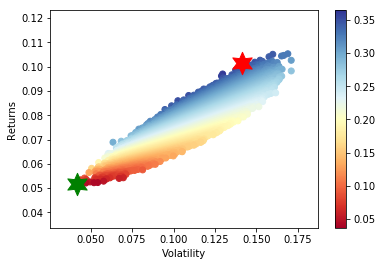

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = port[port.index == port['sharpe'].idxmax()].values.flatten()
#locate positon of portfolio with minimum standard deviation
min_vol_port = port[port.index == port['stdv'].idxmin()].values.flatten()


plt.xlabel('Volatility')
plt.ylabel('Returns')
fig1 = plt.scatter(port['stdv'], port['return'] , c=port.sharpe,cmap='RdYlBu')


#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(6,1,0),color='r',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(6,1,0),color='g',s=500)

plt.colorbar(fig1)
plt.show()


Method 2, Again Markowitz but Using cvxopt Package
==

In [109]:
returns = prices.pct_change(-1).dropna(how='all')
returns2 = returns.iloc[:,5:10].T
returns2

date,2017-11-24 00:00:00,2017-11-22 00:00:00,2017-11-21 00:00:00,2017-11-20 00:00:00,2017-11-17 00:00:00,2017-11-16 00:00:00,2017-11-15 00:00:00,2017-11-14 00:00:00,2017-11-13 00:00:00,2017-11-10 00:00:00,...,2003-06-17 00:00:00,2003-06-16 00:00:00,2003-06-13 00:00:00,2003-06-12 00:00:00,2003-06-11 00:00:00,2003-06-10 00:00:00,2003-06-06 00:00:00,2003-06-05 00:00:00,2003-06-04 00:00:00,2003-06-03 00:00:00
G_Fund,0.000129,0.000065,0.000065,0.000200,0.000065,0.000065,0.000065,0.000065,0.000194,0.000065,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000,0.000000,0.000000,0.000000,0.000000
F_Fund,-0.000740,0.002343,0.000859,-0.000548,0.000410,-0.000958,0.001920,0.000977,0.000150,-0.003586,...,-0.002976,-0.001980,0.001984,0.000993,0.000000,0.007000,0.000000,-0.001996,0.000999,0.004012
C_Fund,0.002106,-0.000661,0.006555,0.001318,-0.002598,0.008508,-0.005296,-0.002148,0.001005,-0.000549,...,0.000953,0.022417,-0.010608,0.001932,0.012720,-0.002927,-0.001947,0.003910,0.014881,0.004985
S_Fund,0.001801,-0.000389,0.008713,0.005022,0.004329,0.012106,-0.004495,-0.002573,0.000530,0.001045,...,0.000962,0.016618,-0.011594,0.002907,0.012758,-0.005854,-0.004854,0.009804,0.015936,-0.000995
I_Fund,0.008805,0.004777,0.004056,0.001018,0.000285,0.006252,-0.005383,-0.000238,-0.006705,-0.001530,...,0.008475,0.012393,-0.004744,0.004766,0.016473,-0.004822,0.008755,0.009823,0.005929,-0.004916


In [110]:
returns_vector = returns2.as_matrix()*252
returns_vector

array([[ 0.0325134 ,  0.01625775,  0.0162588 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.18658621,  0.59037966,  0.21651885, ..., -0.50299401,
         0.25174825,  1.0110331 ],
       [ 0.53077948, -0.16644969,  1.65177066, ...,  0.98533724,
         3.75      ,  1.25623131],
       [ 0.4537446 , -0.09802582,  2.19566854, ...,  2.47058824,
         4.01593625, -0.25074627],
       [ 2.21874699,  1.20371198,  1.02220288, ...,  2.47544204,
         1.49407115, -1.23893805]])

In [99]:
N = 1000
mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
S = opt.matrix(np.cov(returns_vector))
pbar = opt.matrix(np.mean(returns_vector, axis=1))

In [100]:
n=len(returns_vector)
G = -opt.matrix(np.eye(n)) 
h = opt.matrix(0.0, (n ,1))
A = opt.matrix(1.0, (1, n))
b = opt.matrix(1.0)

In [101]:
portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]


In [102]:
returns = [blas.dot(pbar, x) for x in portfolios]
risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]



In [104]:
m1 = np.polyfit(returns, risks, 2)
x1 = np.sqrt(m1[2] / m1[0])



In [107]:
wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']


OPTIMAL WEIGHTS
==

In [112]:
opt_weights = pd.DataFrame(np.round(np.asarray(wt)*100), index = returns2.index , columns=['weights'])
opt_weights

,weights
G_Fund,0.0
F_Fund,52.0
C_Fund,0.0
S_Fund,48.0
I_Fund,0.0


In [125]:
opt_return = np.dot(opt_weights.T, pbar).flatten()
print("optimial selection return is {x} percent".format(x=opt_return))

optimial selection return is: [ 8.46709916] percent


Method 3, Using Different Optimization Criteria and `universal' Package
==

In [153]:

from universal import tools
from universal import algos
import logging
# we would like to see algos progress
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.DEBUG)


In [166]:
algo = algos.OLMAR(window=5, eps=10)
results = algo.run(prices)

2017-11-26 00:42:12,004 Running OLMAR...
2017-11-26 00:42:12,784 Progress: 10.0%...
2017-11-26 00:42:13,655 Progress: 20.0%...
2017-11-26 00:42:14,673 Progress: 30.0%...
2017-11-26 00:42:15,545 Progress: 40.0%...
2017-11-26 00:42:16,480 Progress: 50.0%...
2017-11-26 00:42:17,331 Progress: 60.0%...
2017-11-26 00:42:18,175 Progress: 70.0%...
2017-11-26 00:42:19,071 Progress: 80.0%...
2017-11-26 00:42:19,983 Progress: 90.0%...
2017-11-26 00:42:20,841 OLMAR finished successfully.


ModuleNotFoundError: No module named 'algos'

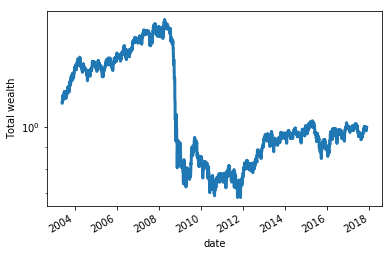

In [167]:
# results.annualized_return()
results.plot(weights=False, assets=False, ucrp=True, logy=True)


In [170]:
print(results.summary())

AttributeError: 'DatetimeIndex' object has no attribute 'order'

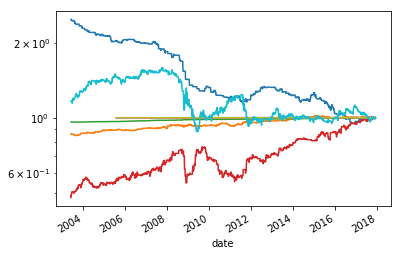

In [171]:
results.plot_decomposition(legend=False, logy=True)


In [172]:
# find name of the most profitable asset
most_profitable = results.equity_decomposed.iloc[-1].argmax()

# rerun an algorithm on data without it
result_without = algo.run(prices.drop([most_profitable], 1))

# and print results
print(result_without.summary())
result_without.plot(weights=False, assets=False, ucrp=True, logy=True)


/Users/rhadadi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  
2017-11-26 00:44:26,625 Running OLMAR...
2017-11-26 00:44:27,417 Progress: 10.0%...
2017-11-26 00:44:28,188 Progress: 20.0%...
2017-11-26 00:44:28,964 Progress: 30.0%...
2017-11-26 00:44:29,828 Progress: 40.0%...
2017-11-26 00:44:30,687 Progress: 50.0%...
2017-11-26 00:44:31,439 Progress: 60.0%...
2017-11-26 00:44:32,201 Progress: 70.0%...
2017-11-26 00:44:32,957 Progress: 80.0%...
2017-11-26 00:44:33,729 Progress: 90.0%...
2017-11-26 00:44:34,687 OLMAR finished successfully.


AttributeError: 'DatetimeIndex' object has no attribute 'order'

In [176]:

pfopt.tangency_portfolio(cov_matrix, mean_daily_returns).values

array([  1.06572683e-02,   2.28310143e-08,   1.76876442e-08,
         1.46975889e-08,   1.48428641e-03,   9.74465315e-01,
         1.33930598e-02,   6.90762293e-09,   3.20075420e-09,
         5.53397101e-09])

In [185]:
#!/usr/bin/python

# The MIT License (MIT)
#
# Copyright (c) 2015 Christian Zielinski
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULtAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

import numpy as np
import pandas as pd

import portfolioopt as pfopt


def section(caption):
    print('\n\n' + str(caption))
    print('-' * len(caption))


def print_portfolio_info(returns, avg_rets, weights):
    """
    Print information on expected portfolio performance.
    """
    ret = (weights * avg_rets).sum()
    std = (weights * returns).sum(1).std()
    sharpe = ret / std
    print("Optimal weights:\n{}\n".format(weights))
    print("Expected return:   {}".format(ret))
    print("Expected variance: {}".format(std**2))
    print("Expected Sharpe:   {}".format(sharpe))


def main():
    returns =returns2 *252
    cov_mat=cov_matrix
    avg_rets = mean_daily_returns *252
    
    section("Example returns")
    print(returns.head(10))
    print("...")

    section("Average returns")
    print(avg_rets)

    section("Covariance matrix")
    print(cov_mat)

    section("Minimum variance portfolio (long only)")
    weights = pfopt.min_var_portfolio(cov_mat)
    print_portfolio_info(returns, avg_rets, weights)

#     section("Minimum variance portfolio (long/short)")
#     weights = pfopt.min_var_portfolio(cov_mat, allow_short=True)
#     print_portfolio_info(returns, avg_rets, weights)

    # Define some target return, here the 70% quantile of the average returns
    target_ret = avg_rets.quantile(0.7)

    section("Markowitz portfolio (long only, target return: {:.5f})".format(target_ret))
    weights = pfopt.markowitz_portfolio(cov_mat, avg_rets, target_ret)
    print_portfolio_info(returns, avg_rets, weights)

#     section("Markowitz portfolio (long/short, target return: {:.5f})".format(target_ret))
#     weights = pfopt.markowitz_portfolio(cov_mat, avg_rets, target_ret, allow_short=True)
#     print_portfolio_info(returns, avg_rets, weights)

#     section("Markowitz portfolio (market neutral, target return: {:.5f})".format(target_ret))
#     weights = pfopt.markowitz_portfolio(cov_mat, avg_rets, target_ret, allow_short=True,
#                                                                        market_neutral=True)
#     print_portfolio_info(returns, avg_rets, weights)

    section("Tangency portfolio (long only)")
    weights = pfopt.tangency_portfolio(cov_mat, avg_rets)
    weights = pfopt.truncate_weights(weights)   # Truncate some tiny weights
    print_portfolio_info(returns, avg_rets, weights)

#     section("Tangency portfolio (long/short)")
#     weights = pfopt.tangency_portfolio(cov_mat, avg_rets, allow_short=True)
#     print_portfolio_info(returns, avg_rets, weights)


if __name__ == '__main__':
    main()




Example returns
---------------
date    2017-11-24  2017-11-22  2017-11-21  2017-11-20  2017-11-17  \
G_Fund    0.032513    0.016258    0.016259    0.050412    0.016263   
F_Fund   -0.186586    0.590380    0.216519   -0.138217    0.103356   
C_Fund    0.530779   -0.166450    1.651771    0.332042   -0.654722   
S_Fund    0.453745   -0.098026    2.195669    1.265573    1.090860   
I_Fund    2.218747    1.203712    1.022203    0.256655    0.071783   

date    2017-11-16  2017-11-15  2017-11-14  2017-11-13  2017-11-10  \
G_Fund    0.016264    0.016265    0.016266    0.048808    0.016270   
F_Fund   -0.241398    0.483723    0.246296    0.037790   -0.903701   
C_Fund    2.144025   -1.334487   -0.541405    0.253234   -0.138368   
S_Fund    3.050650   -1.132804   -0.648439    0.133445    0.263368   
I_Fund    1.575494   -1.356556   -0.059995   -1.689591   -0.385506   

date       ...      2003-06-17  2003-06-16  2003-06-13  2003-06-12  \
G_Fund     ...        0.000000    0.000000    0.000000

/Users/rhadadi/anaconda/lib/python3.6/site-packages/pandas/core/indexes/base.py:3137: RuntimeWarning: Cannot compare type 'Timestamp' with type 'str', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)
